# **Data Visualization**
---

## Objective

- Answer business requirement 1:
    * The client wants to make sure that the animal images are distinguishable from one another and can be used to train a model.

## Inputs

- The folder `inputs/datasets/pets` containing the subfolders `train`, `test`, and `validation`
- The correctly labelled folders in each of these subfolders
- An adequate amount of preprocessed png images (size 128x128) in each labelled folder, showing a snapshot of a pet coming up to a bowl

## Outputs

- Image shape pickle file
- Mean image for each label
- Histograms showing the differences between the means
- Code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard

---
## Preparation
### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread
from tensorflow.keras.preprocessing import image
from PIL import Image
import random

sns.set_style("white")


### Set the correct working directory

In [2]:
# Check the current working directory
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5\\jupyter_notebooks'

In [3]:
# Move up to the project top directory
os.chdir(os.path.dirname(cwd))
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5'

### Set the main paths and constant variables

It was decided that the input shape of the images that the model will be trained on shall be (128, 128, 3).

In [4]:
dataset_name = "pets"
full_dataset_path = os.path.normpath(os.path.join(cwd, 'inputs/datasets', dataset_name))
output_path = os.path.join(cwd, 'outputs')
train_path = os.path.join(full_dataset_path, 'train')
test_path = os.path.join(full_dataset_path, 'test')
validation_path = os.path.join(full_dataset_path, 'validation')

INPUT_SHAPE = (-1, 128, 128, 3)
joblib.dump(INPUT_SHAPE, f'{output_path}/input_shape.pkl')
LABELS = sorted(joblib.load(f'{output_path}/class_dict.pkl').values())

# The following line should show a list containing the subsets of the split dataset
os.listdir(full_dataset_path)

['test', 'train', 'validation']

### Util function to highlight errors and warnings

In [5]:
from colorama import Fore, Style

# Error notification style
def print_err(message):
    print(f'{Fore.RED}ERROR:{Style.RESET_ALL}\n{message}')

# Warning notification style
def print_warn(message):
    print(f'{Fore.YELLOW}WARNING:{Style.RESET_ALL}\n{message}')

### Util function to display a progress bar

In [52]:
def show_progress(label, list_len):
    width = 100
    for i in range(list_len):
        yield f'\r{label:<10}: {"#"*int(width if i == list_len-1 else i//(list_len/width)):<{width}}|| '


In [87]:
def set_ticks(ax):
    ax.set_xticks([])
    ax.set_yticks([])

---
## Step 1
### Show image montage

Let's take a look at our dataset to make sure it is useable.

In [90]:
import itertools

def show_montage(nrows, ncols, labels):
    
    list_rows = range(0, nrows)
    list_cols = range(0, ncols)
    plot_idx = list(itertools.product(list_rows, list_cols))

    for label in labels:
        label_path = os.path.join(train_path, label)
        label_files = os.listdir(label_path)
        rnd_sample = random.sample(label_files, nrows*ncols)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
        for idx, img in enumerate(rnd_sample):
            img = np.asarray(Image.open(os.path.join(label_path, img)))/255.0
            axes[plot_idx[idx][0], plot_idx[idx][1]].imshow(img)
            set_ticks(axes[plot_idx[idx][0], plot_idx[idx][1]])

        plt.suptitle(t=f'\n{label.upper()}:\n', fontsize='x-large')
        plt.axis('off')
        plt.tight_layout()
        plt.show()


### Display the montage.

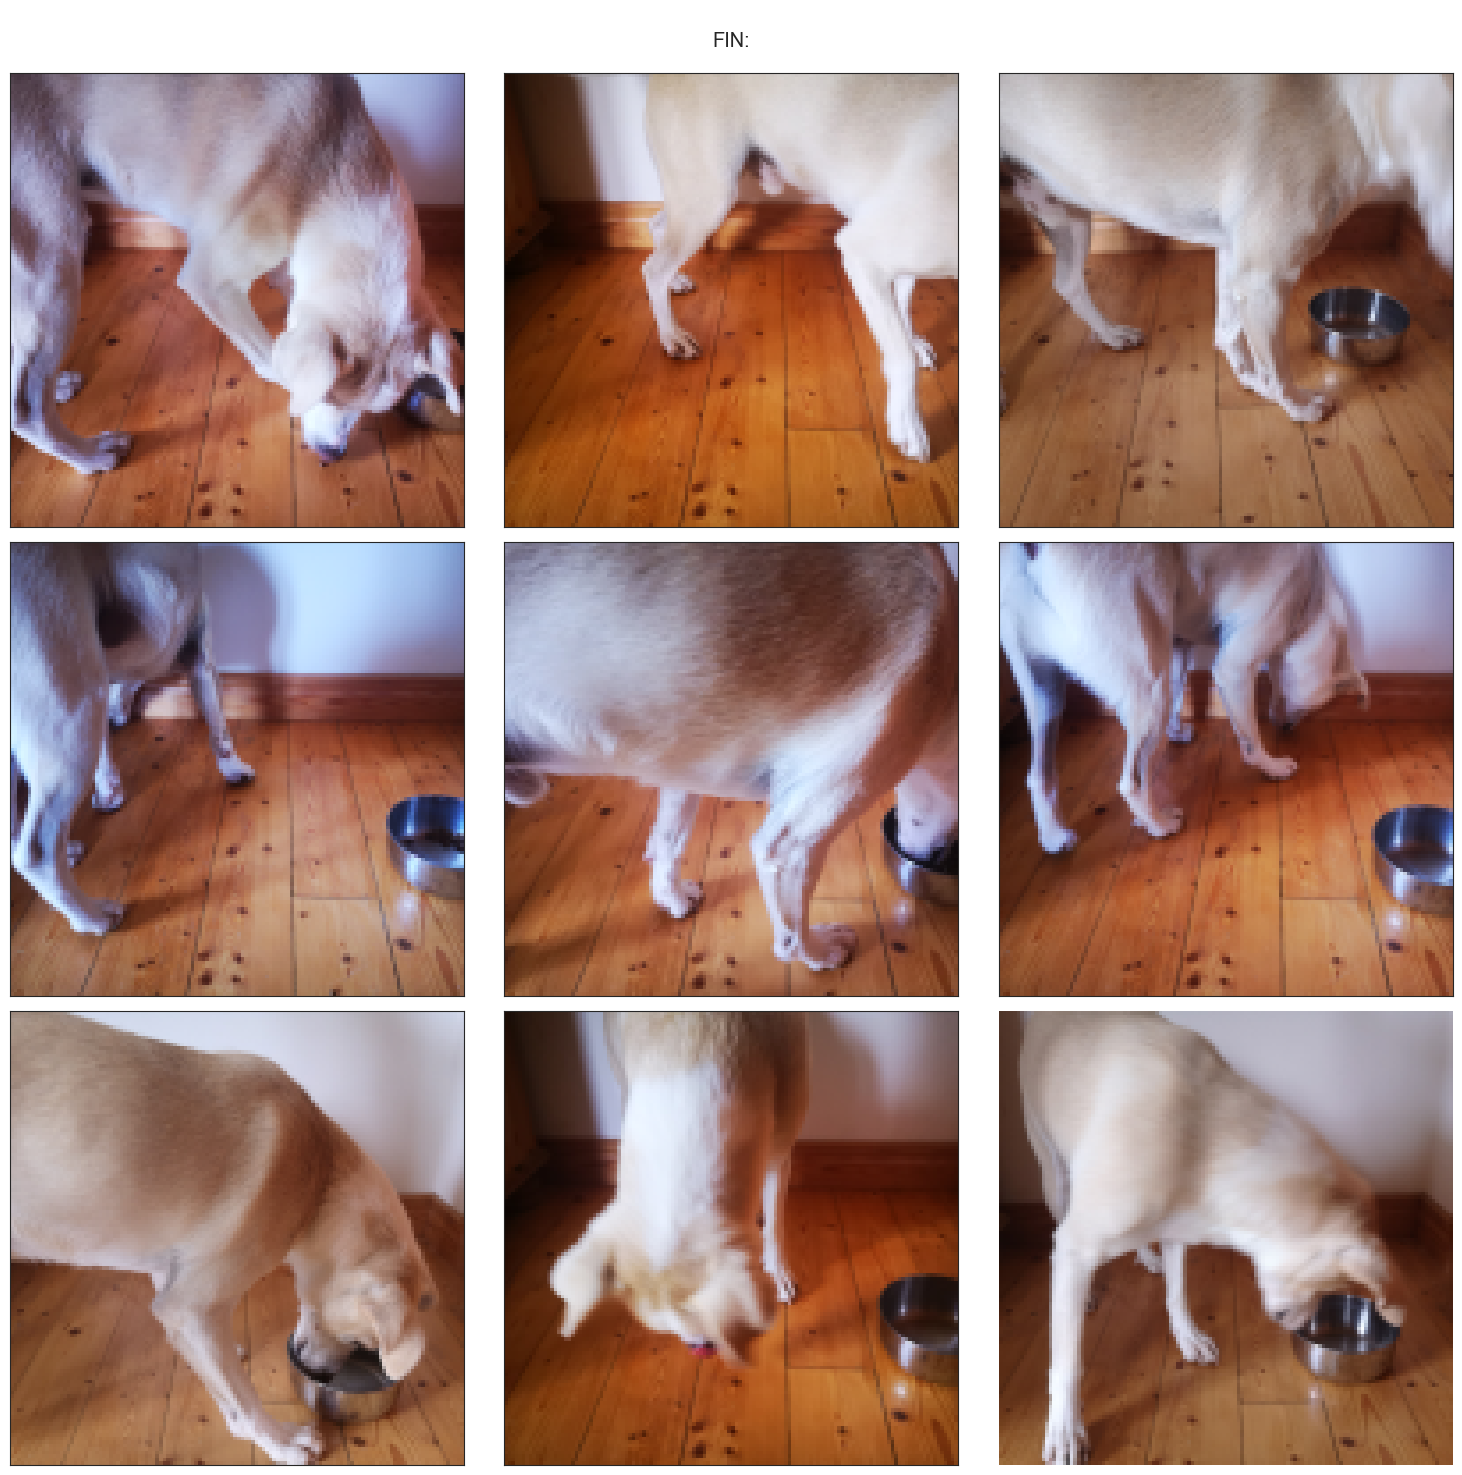

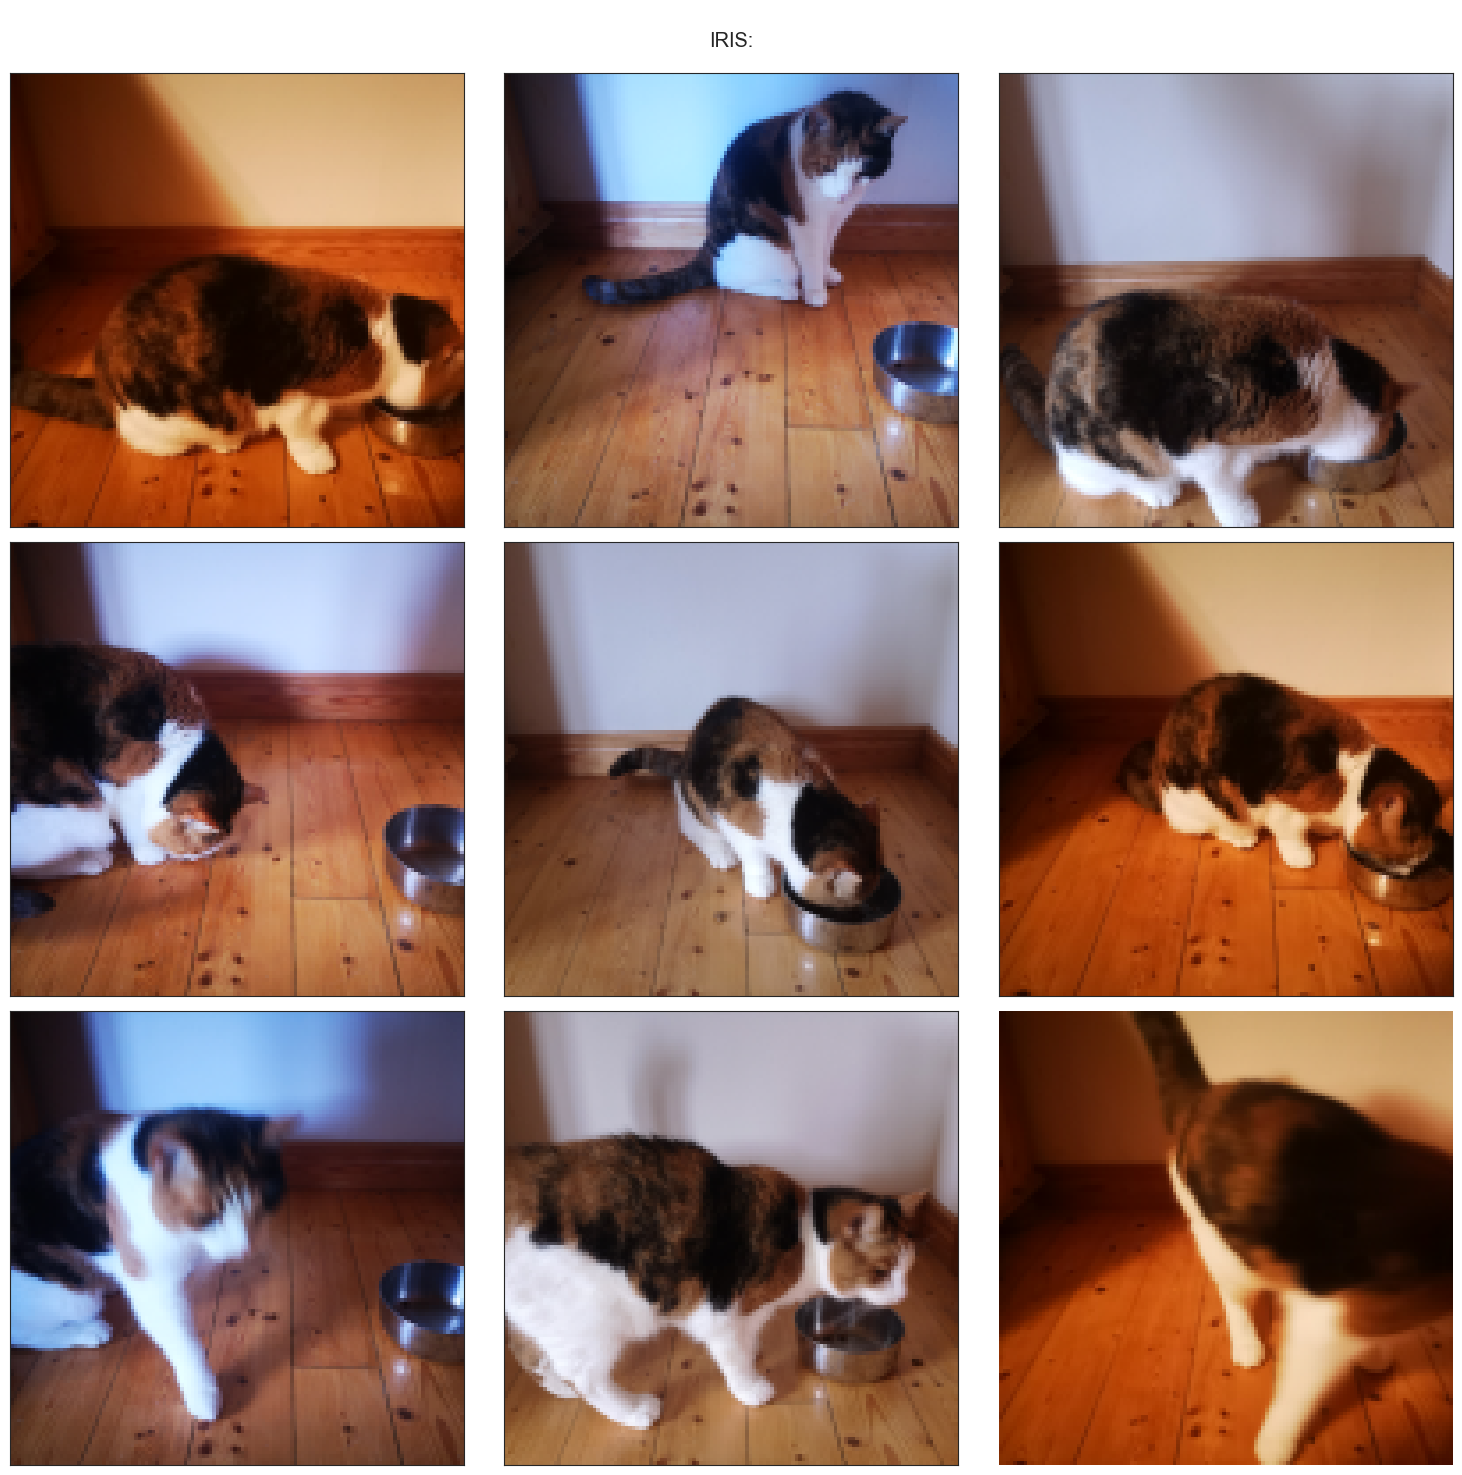

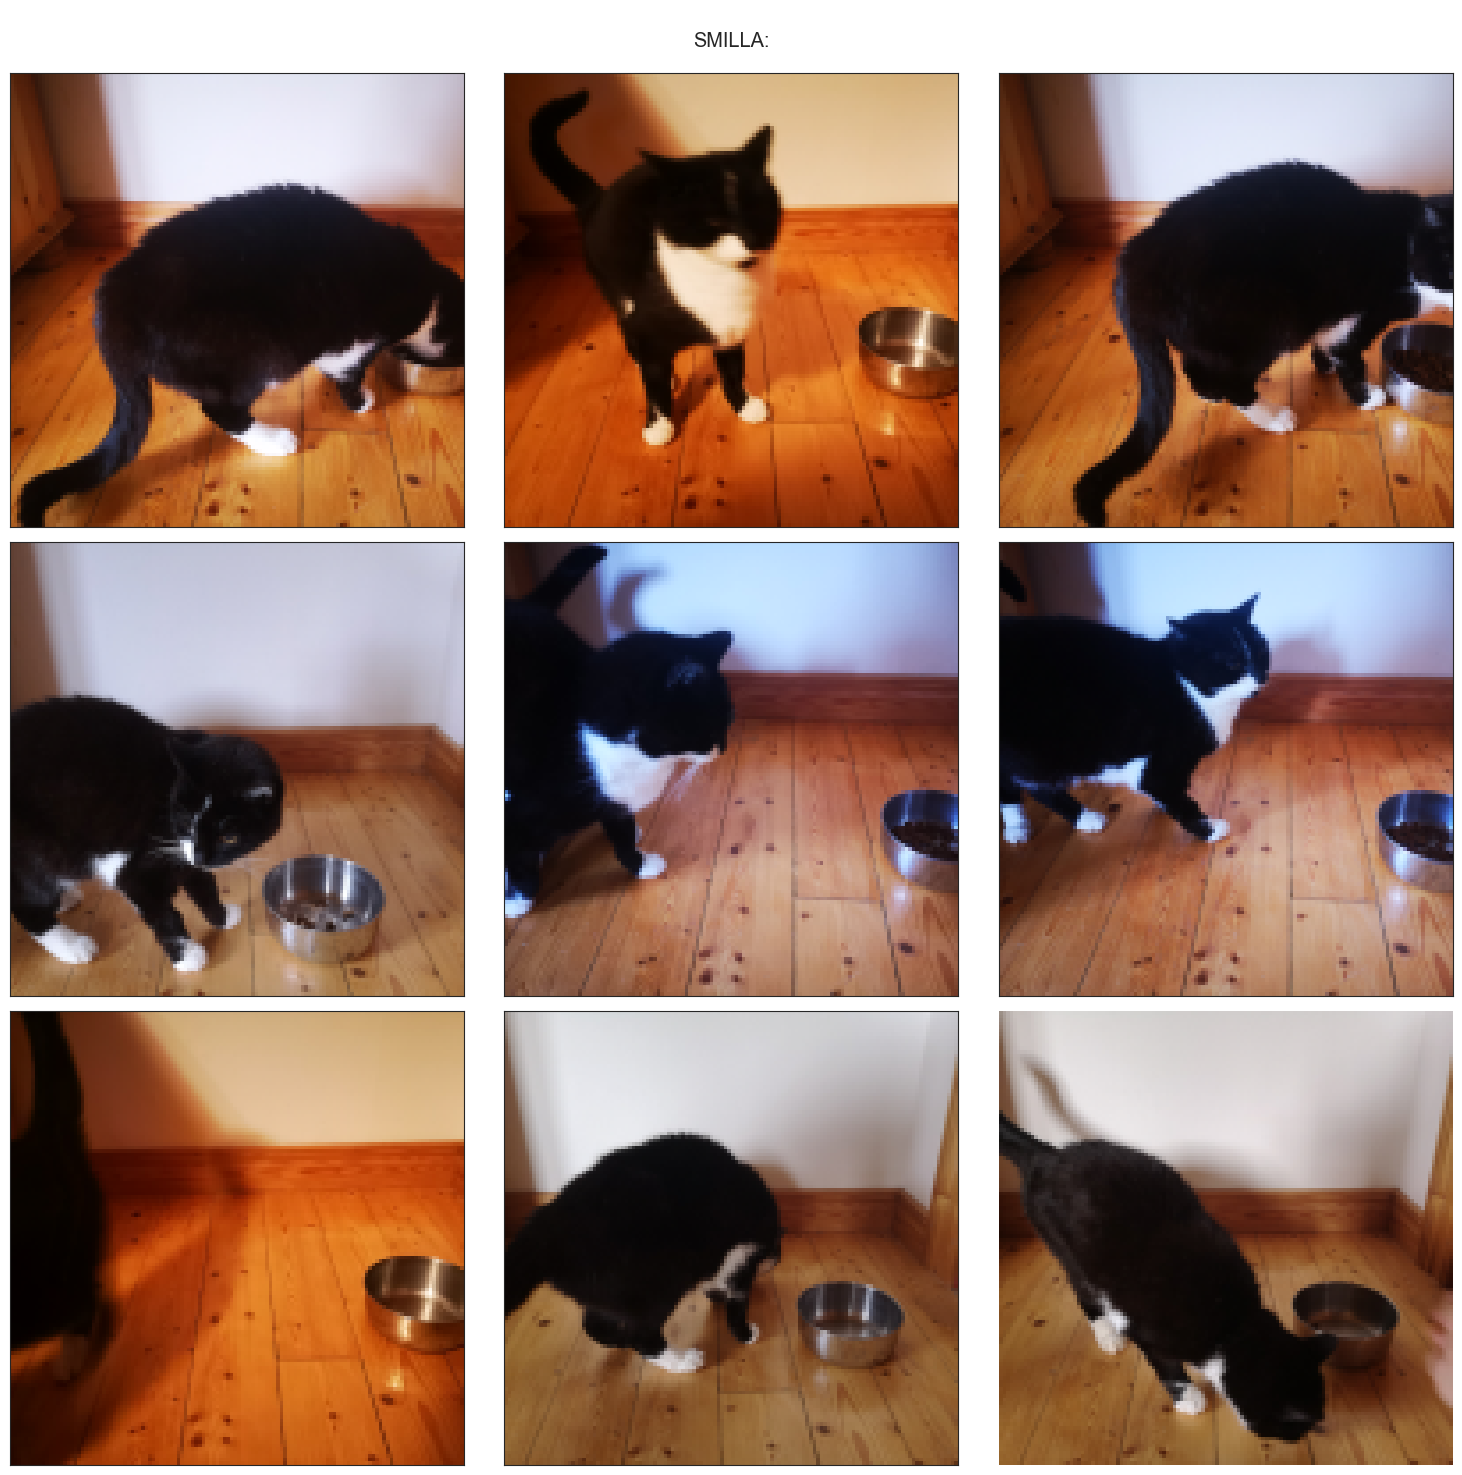

In [89]:
show_montage(3, 3, LABELS)

## Step 2
### Load image sample for visualization

Function to load all images into an array

In [54]:
# Load images from specified folder, resize them, save them as np array in X and save their labels in y
def save_images_in_array(path, shape, amount):
    
    dims = tuple(shape[1:3])
    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    print(f'Loading from {path}:')
    
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        # Select a given amount of random images from the provided folder
        img_list = random.sample(os.listdir(label_path), min(amount, len(os.listdir(label_path))))
        # Initialize progress bar generator
        progress_bar = show_progress(label, len(img_list))

        for img_name in img_list:
            img = image.load_img(os.path.join(path, label, img_name))
            if img.size != dims:
                img = img.resize(dims, resample=Image.LANCZOS)
            img_resized = image.img_to_array(img)
            if img_resized.max() > 1:
                img_resized = img_resized / 255.0
            X = np.append(X, img_resized).reshape(shape)
            y = np.append(y, label)
            print(next(progress_bar), end='')

        print(f'{len(img_list)} images loaded')

    # Shuffle the image set
    train_set = list(zip(y, X))
    random.shuffle(train_set)
    y_shuffled, X_shuffled = list(map(list, zip(*train_set)))
    X = np.array(X_shuffled, dtype='float32')
    y = np.array(y_shuffled, dtype='object')
    
    return X, y

            

In [55]:
# Load a sample of training images into an array
X_sample, y_sample = save_images_in_array(train_path, INPUT_SHAPE, amount=150)

Loading from d:\Projekte\Coding\CodeInstitute\PP5\inputs\datasets\pets\train:
fin       : ####################################################################################################|| 150 images loaded
iris      : ####################################################################################################|| 150 images loaded
smilla    : ####################################################################################################|| 150 images loaded


## Step 3
### Show average images for each label

First, we create a dictionary containing the mean images for each label.

In [93]:
# Create a dictionary with the mean images of all labels
import itertools
import functools


def get_means(X, y, labels):

    compound_dict = {'means': {}, 'vars': {}}

    for label in labels:
        y = y.reshape(-1, 1, 1)
        bool_mask = np.any(y == label, axis=1).reshape(-1)
        arr = X[bool_mask]
        X_mean = np.mean(arr, axis=0)
        X_var = np.std(arr, axis=0)
        compound_dict['means'][label] = X_mean
        compound_dict['vars'][label] = X_var
        
    return compound_dict


In [94]:
compound_dict = get_means(X_sample, y_sample, LABELS)

Then we display the mean image for each label.

In [123]:
def calc_figure(amount):
    """Util function to calculate figure size depending on label amount

    Args:
        labels (list): List with all label names

    Returns:
        int: Amount of columns
        int: Amount of rows
        list: Coordinates for all label mean images
    """
    
    if (amount%3 == 0 and amount%2 == 0 and amount%4 != 0) or (amount%3 == 0 and amount <= 6):
        ncols = 3
    elif amount == 2:
        ncols = 2
    else:
        ncols = max(min(2, amount + (amount % 3)), 4)

    nrows = max(1, (1 if amount%ncols != 0 else 0) + amount // ncols)

    if amount - ncols == 1 or amount - ncols * (nrows-1) == 1:
        ncols = 3
        nrows = max(1, (1 if amount%ncols != 0 else 0) + amount // ncols)

    coords = list(itertools.product(range(nrows), range(ncols)))[:amount]

    return ncols, nrows, coords


def show_means(img_dict, img_type, labels):
    """Display the mean image for each label in a grid

    Args:
        img_dict (dict): Dictionary with mean or variance images as numpy arrays
        labels (list): list with all label names
    """

    ncols, nrows, coords = calc_figure(len(labels))
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows*5))
    
    # Hide the axes of unused plots
    for ax in axes:
        if nrows == 1:
            ax.set_axis_off()
        else:
            for plot in ax:
                plot.set_axis_off()

    for idx, coord in enumerate(coords):
        if nrows > 1:
            axes[coord[0]][coord[1]].set_title(f"{img_type} image for label {labels[idx]}")
            axes[coord[0]][coord[1]].imshow(img_dict[labels[idx]])
            set_ticks(axes[coord[0]][coord[1]])
        else:
            axes[idx].set_title(f"{img_type} image for label {labels[idx]}")
            axes[idx].imshow(img_dict[labels[idx]])
            set_ticks(axes[idx])

    plt.tight_layout()
    plt.savefig(f'{output_path}/{img_type.lower()}_images_grid.png',
            bbox_inches='tight', dpi=150)
    plt.show()

        

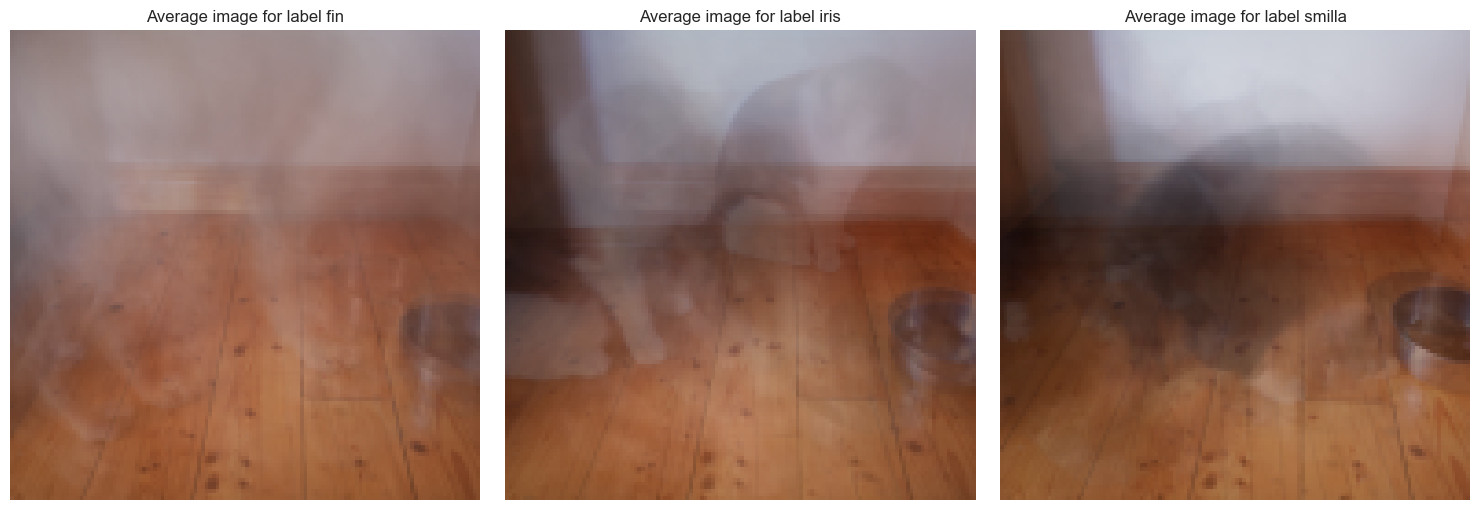

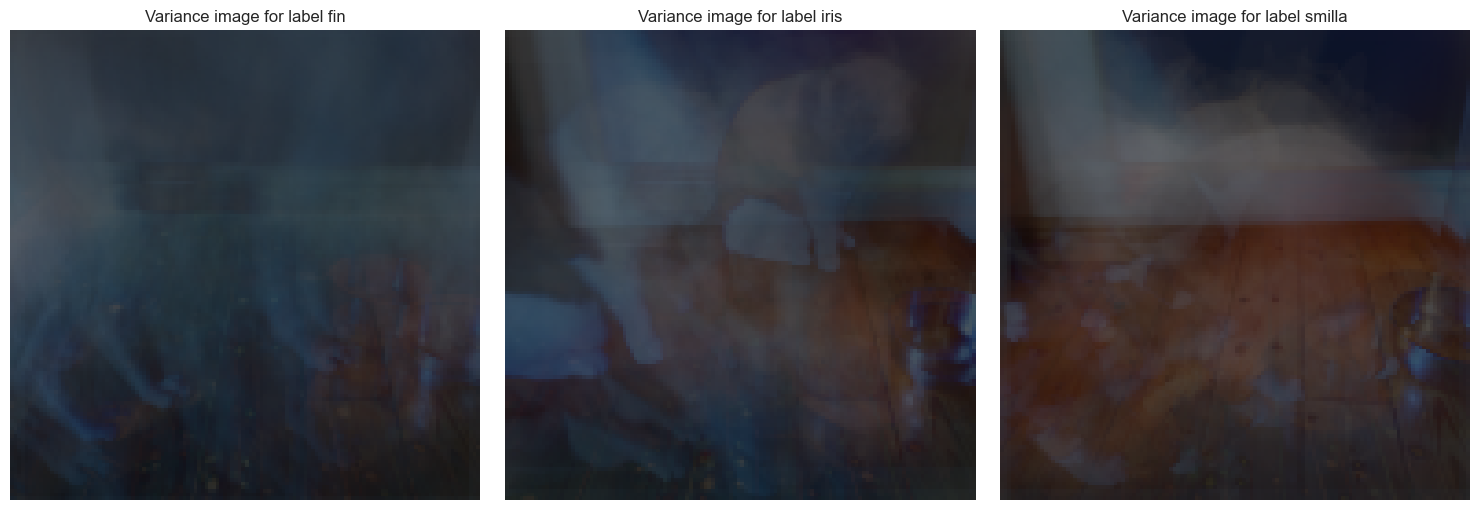

In [124]:
show_means(compound_dict['means'], 'Average', LABELS)
show_means(compound_dict['vars'], 'Variance', LABELS)


The images seem distinguishable from each other. However, we want to be able to make a recommendation based on an explicit number or graph that will show whether our model architecture is suitable for the given image sets.
First, we look for a baseline that shows the differences between the mean images.

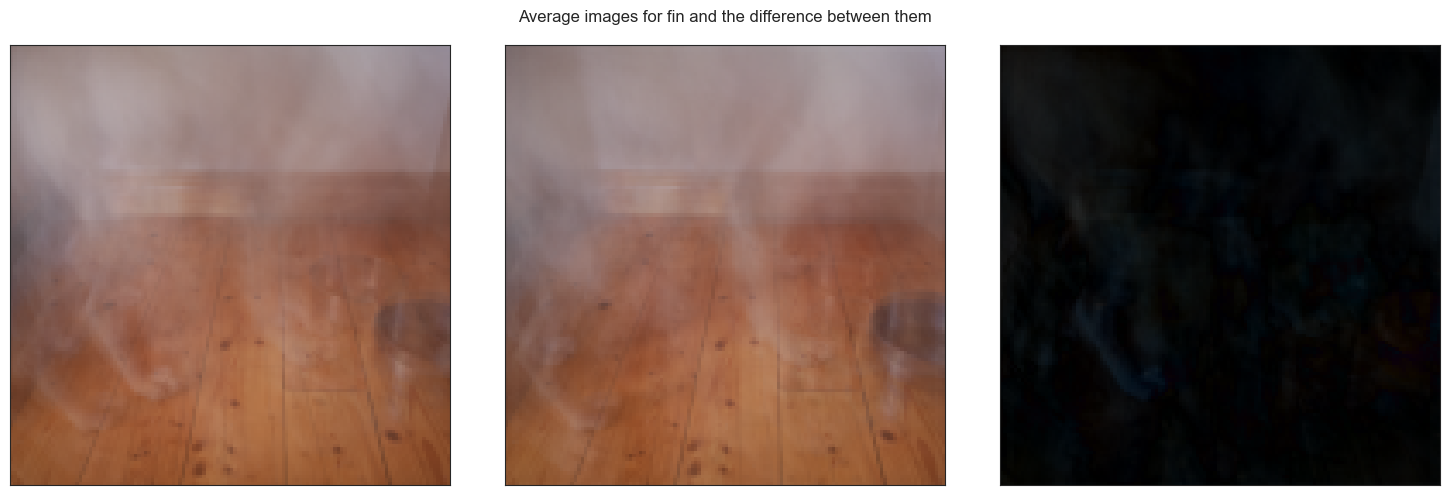

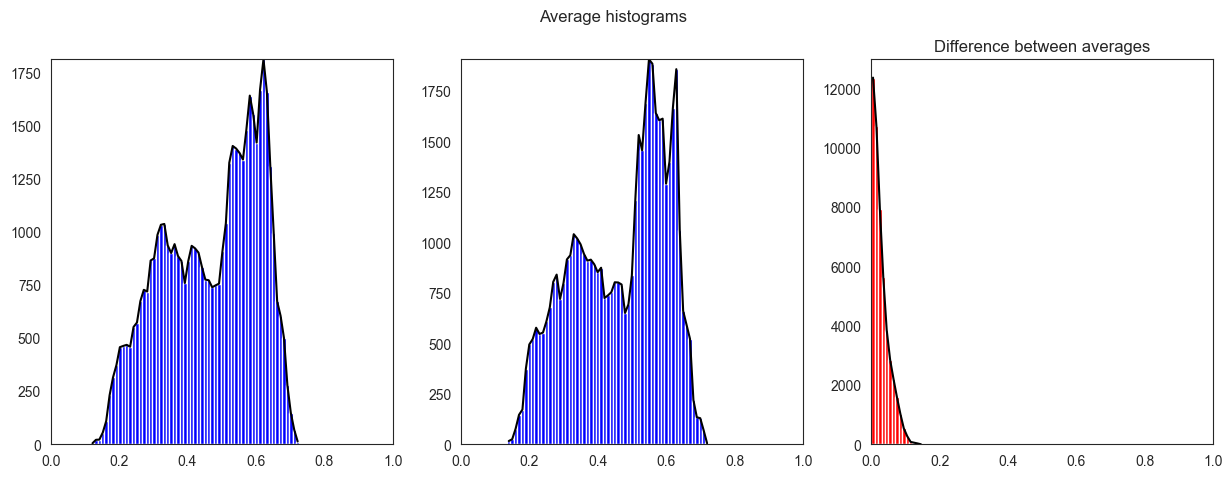

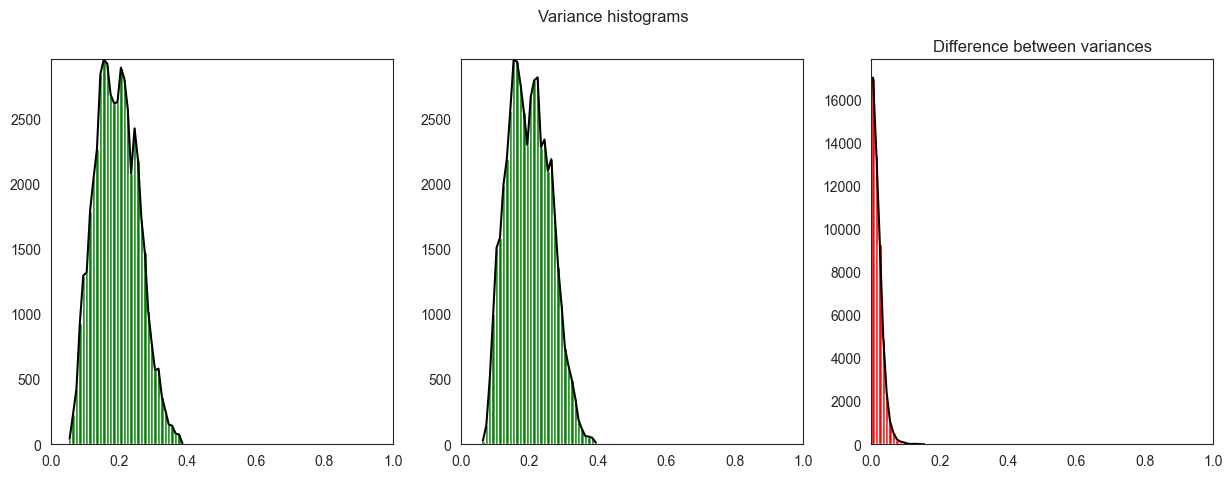

mean 1 0.4693974554538727 mean 2 0.4647458791732788 diff 0.028208129107952118
var 1 0.06117629259824753 var 2 0.0610433965921402 diff 0.015648094937205315


In [138]:
def show_hist(img_1, img_2, graph_color, img_type):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    plt.suptitle(f'{img_type.capitalize()} histograms')
    y_lim = 0
    for ax, img, color in zip(axes, [img_1, img_2, abs(img_1-img_2)], [graph_color, graph_color, 'red']):
        data = img.flatten()
        y_val, bin_edges, patches = ax.hist(data, bins=np.arange(min(data), max(data) + 0.01, 0.01), color=color)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        ax.plot(bin_centers, y_val, '-', c='black')
        ax.set(xlim=(0, 1))
    for ax in axes[:2]:
        y_lim = max(np.array([i.get_height() for i in ax.patches]).max(), y_lim)
        ax.set(ylim=(0, y_lim))
    axes[2].set_title(f'Difference between {img_type}s')
    plt.show()


def find_baseline(X, y, labels):
    
    y = y.reshape(-1, 1, 1)
    bool_mask = np.any(y == labels[0], axis=1).reshape(-1)
    arr = X[bool_mask]
    
    mid_idx = int(len(arr)//2)
    
    arr_1, arr_2 = arr[:mid_idx], arr[mid_idx:]
    mean_1 = np.mean(arr_1, axis=0)
    mean_2 = np.mean(arr_2, axis=0)
    mean_diff = abs(mean_1 - mean_2)
    var_1 = np.std(arr_1, axis=0)
    var_2 = np.std(arr_2, axis=0)
    
    #coords = itertools.product(range(2), range(2))
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    plt.suptitle(f'Average images for {labels[0]} and the difference between them')
    for ax, img in zip(axes, [mean_1, mean_2, mean_diff]):
        ax.imshow(img)
        set_ticks(ax)

    plt.tight_layout()
    plt.show()
    
    # Show average histograms and plot the differences
    show_hist(mean_1, mean_2, 'blue', 'average')
    
    # Show variance histograms and plot the differences
    show_hist(var_1, var_2, 'green', 'variance')

    print(f'mean 1 {np.mean(mean_1)} mean 2 {np.mean(mean_2)} diff {np.mean(abs(mean_1 - mean_2))}')
    print(f'var 1 {np.std(var_1)} var 2 {np.std(var_2)} diff {np.std(abs(var_1 - var_2))}')



find_baseline(X_sample, y_sample, LABELS)



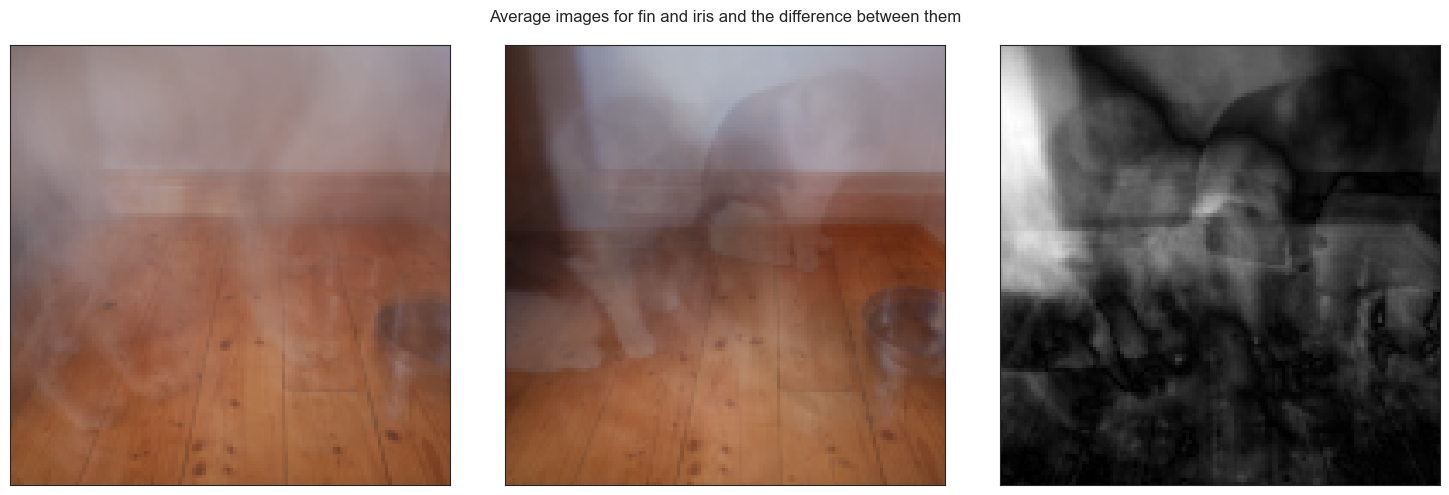

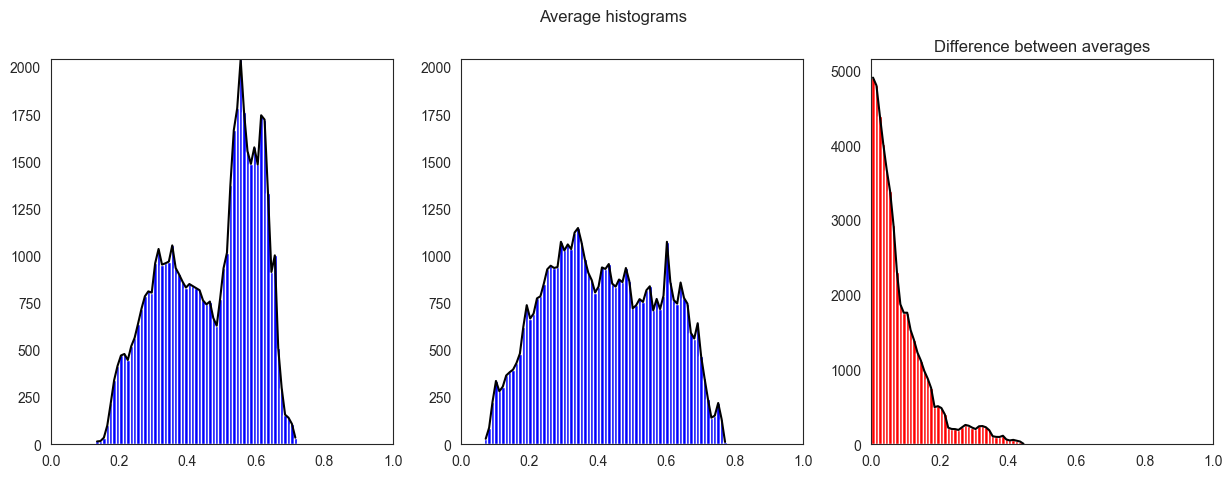

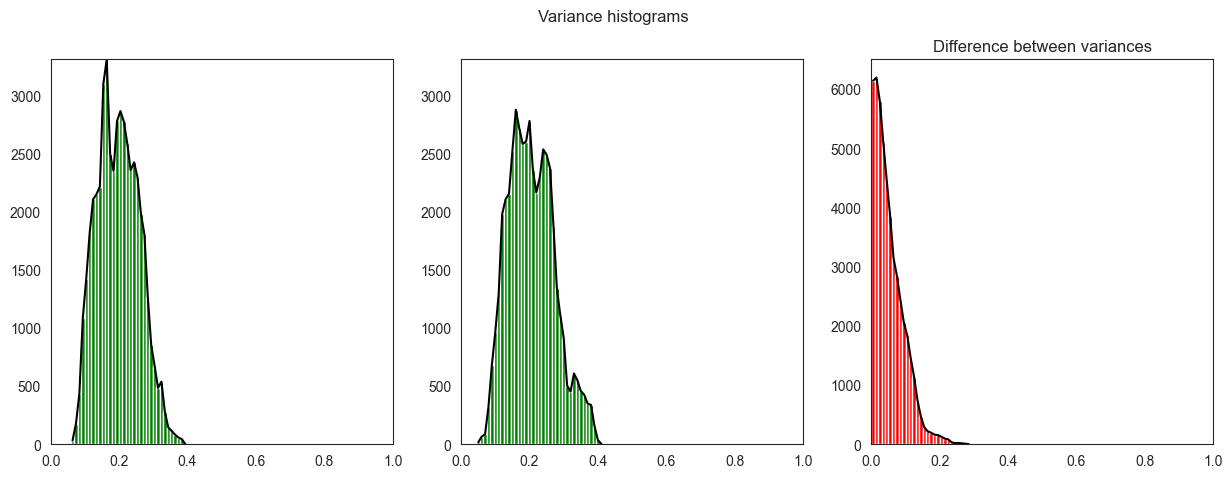

mean 1 0.46707165241241455 mean 2 0.41930535435676575 diff 0.08425325155258179
var 1 0.06017071008682251 var 2 0.06701134145259857 diff 0.042720261961221695


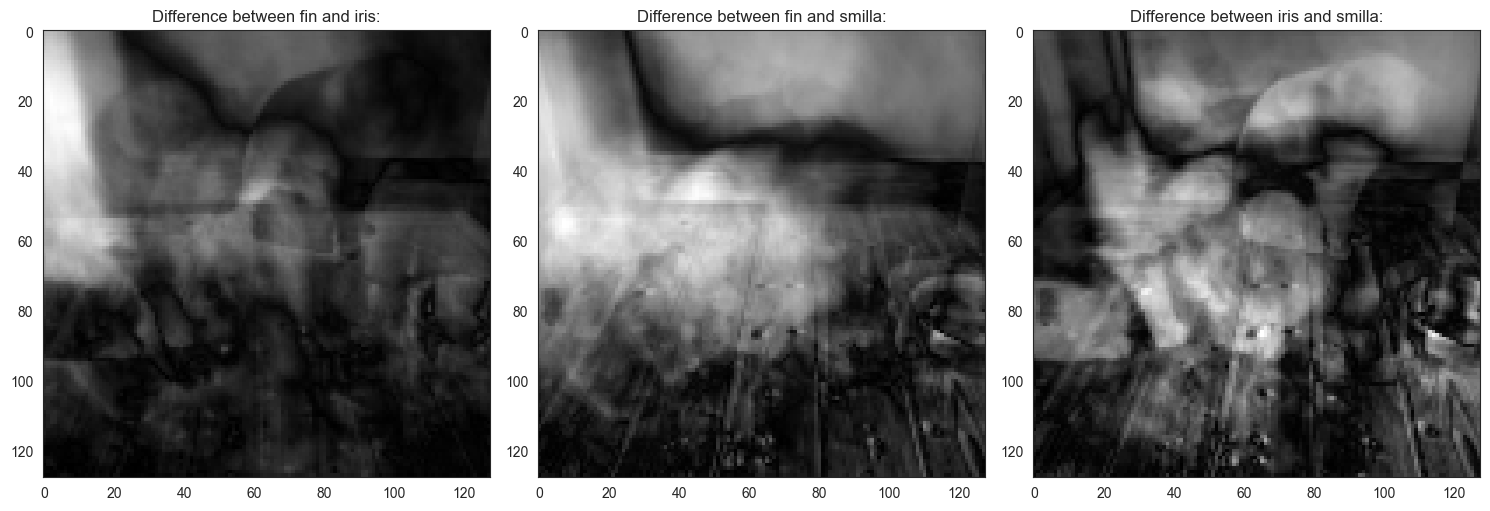

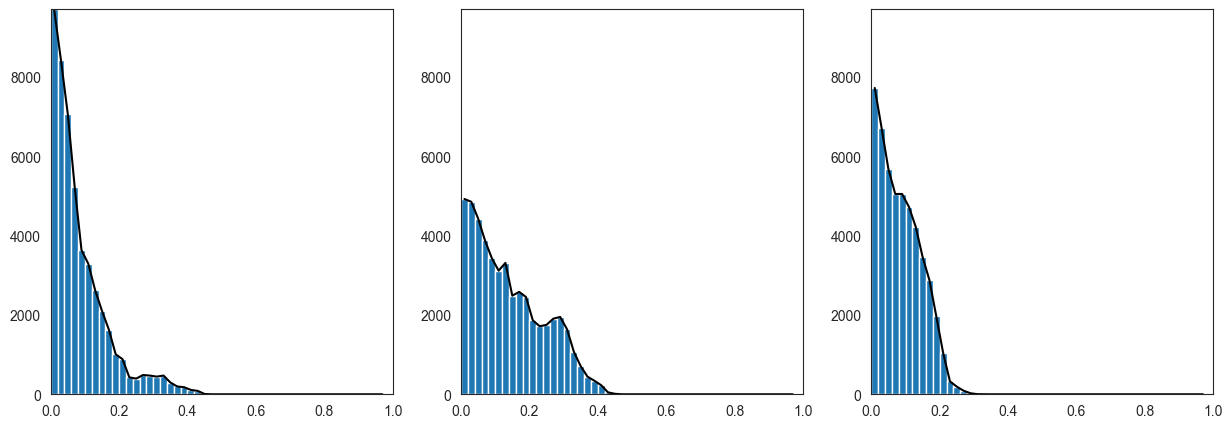

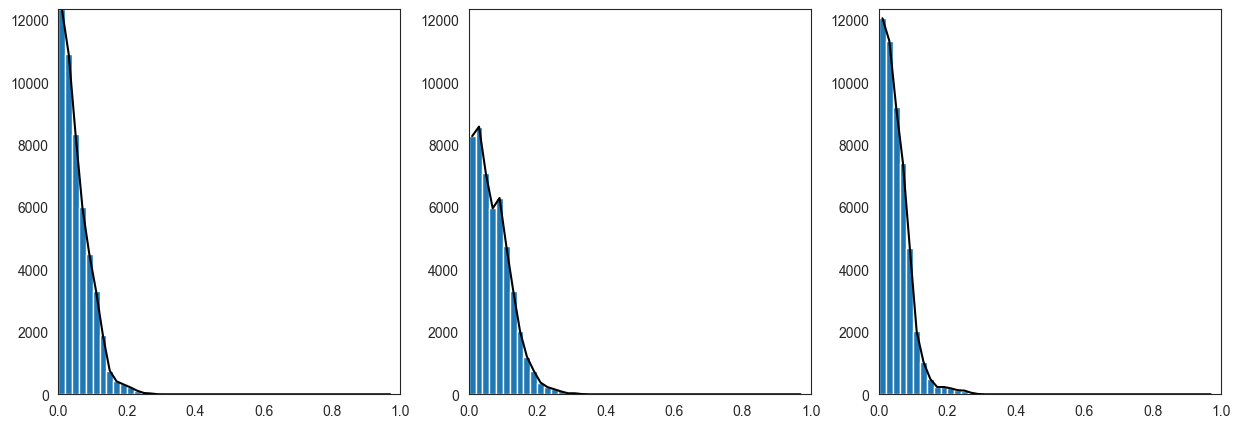

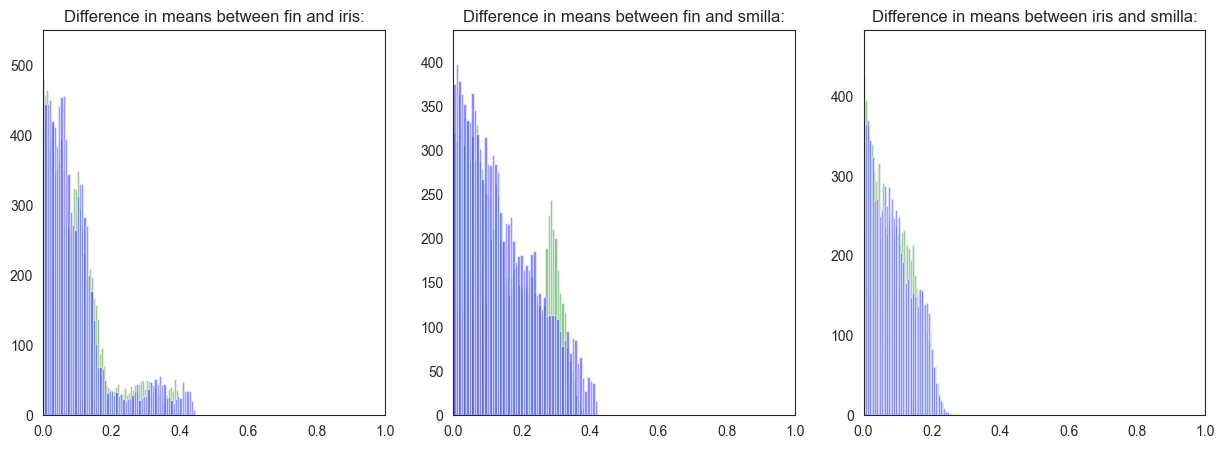

In [153]:
from skimage.color import rgb2gray
# Compare all labels

def compare_labels(X, y, labels, comp_dict):

    mean_1 = comp_dict['means'][labels[0]]
    mean_2 = comp_dict['means'][labels[1]]
    var_1 = comp_dict['vars'][labels[0]]
    var_2 = comp_dict['vars'][labels[1]]
    mean_diff = rgb2gray(abs(mean_1 - mean_2))

    #coords = itertools.product(range(2), range(2))
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    plt.suptitle(f'Average images for {labels[0]} and {labels[1]} and the difference between them')
    for ax, img in zip(axes, [mean_1, mean_2, mean_diff]):
        ax.imshow(img, cmap='gray')
        set_ticks(ax)
    plt.tight_layout()
    plt.show()
    
    # Show average histograms and plot the differences
    show_hist(mean_1, mean_2, 'blue', 'average')
    
    # Show variance histograms and plot the differences
    show_hist(var_1, var_2, 'green', 'variance')

    print(f'mean 1 {np.mean(mean_1)} mean 2 {np.mean(mean_2)} diff {np.mean(abs(mean_1 - mean_2))}')
    print(f'var 1 {np.std(var_1)} var 2 {np.std(var_2)} diff {np.std(abs(var_1 - var_2))}')
    

compare_labels(X_sample, y_sample, LABELS, compound_dict)    

def compare_label_means(X, y, comp_dict, labels):

    means = comp_dict['means']
    vars = comp_dict['vars']

    combos_len = sum(1 for _ in itertools.combinations(labels, 2))
    ncols, nrows, coords = calc_figure(combos_len)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
    for coord, combo in zip(coords, itertools.combinations(labels, 2)):
        mc = rgb2gray(abs(means[combo[0]] - means[combo[1]]))

        if nrows == 1:
            axes[coord[1]].set_title(f"Difference between {combo[0]} and {combo[1]}:")
            axes[coord[1]].imshow(mc, cmap='gray')
        else:
            axes[coord].set_title(f"Difference between {combo[0]} and {combo[1]}:")
            axes[coord].imshow(mc, cmap='gray')
    plt.tight_layout()
    plt.show()
    
    y_lim = 0
    fig, axes = plt. subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
    for coord, combo in zip(coords, itertools.combinations(labels, 2)):
        if nrows == 1:
            params = axes[coord[1]].hist(abs(means[combo[0]] - means[combo[1]]).flatten(), bins=np.arange(0, 1, 0.02))
            bin_centers = 0.5 * (params[1][1:] + params[1][:-1])
            axes[coord[1]].plot(bin_centers, params[0], '-', c='black')
            axes[coord[1]].set(xlim=(0, 1))
        else:
            params = axes[coord].hist(abs(means[combo[0]] - means[combo[1]]).flatten(), bins=np.arange(0, 1, 0.02))
            bin_centers = 0.5 * (params[1][1:] + params[1][:-1])
            axes[coord].plot(bin_centers, params[0], '-', c='black')
            axes[coord].set(xlim=(0, 1))
    if nrows == 1:
        for ax in axes:
            y_lim = max(np.array([i.get_height() for i in ax.patches]).max(), y_lim)
            ax.set(ylim=(0, y_lim))
    else:
        for ax in axes:
            for plot in ax:
                y_lim = max(np.array([i.get_height() for i in plot.patches]).max(), y_lim)
                plot.set(ylim=(0, y_lim))
#    plt.hist((means[combo[0]] - means[combo[1]]).flatten(), bins=100)
    plt.show()
    
    y_lim = 0
    fig, axes = plt. subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
    for coord, combo in zip(coords, itertools.combinations(labels, 2)):
        if nrows == 1:
            params = axes[coord[1]].hist(abs(vars[combo[0]] - vars[combo[1]]).flatten(), bins=np.arange(0, 1, 0.02))
            bin_centers = 0.5 * (params[1][1:] + params[1][:-1])
            axes[coord[1]].plot(bin_centers, params[0], '-', c='black')
            axes[coord[1]].set(xlim=(0, 1))
        else:
            params = axes[coord].hist(abs(vars[combo[0]] - vars[combo[1]]).flatten(), bins=np.arange(0, 1, 0.02))
            bin_centers = 0.5 * (params[1][1:] + params[1][:-1])
            axes[coord].plot(bin_centers, params[0], '-', c='black')
            axes[coord].set(xlim=(0, 1))
    if nrows == 1:
        for ax in axes:
            y_lim = max(np.array([i.get_height() for i in ax.patches]).max(), y_lim)
            ax.set(ylim=(0, y_lim))
    else:
        for ax in axes:
            for plot in ax:
                y_lim = max(np.array([i.get_height() for i in plot.patches]).max(), y_lim)
                plot.set(ylim=(0, y_lim))
      
    plt.show()


    fig, axes = plt. subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
    for coord, combo in zip(coords, itertools.combinations(labels, 2)):
        if nrows == 1:
            axes[coord[1]].set_title(f"Difference in means between {combo[0]} and {combo[1]}:")
            params = axes[coord[1]].hist((means[combo[0]][...,0] - means[combo[1]][...,0]).flatten(), bins=100, alpha=0.5, color='r')
            y_lim = np.array([i.get_height() for i in params[2]]).max()
            params = axes[coord[1]].hist((means[combo[0]][...,1] - means[combo[1]][...,1]).flatten(), bins=100, alpha=0.5, color='g')
            y_lim = max(np.array([i.get_height() for i in params[2]]).max(), y_lim)
            params = axes[coord[1]].hist((means[combo[0]][...,2] - means[combo[1]][...,2]).flatten(), bins=100, alpha=0.5, color='b')
            y_lim = max(np.array([i.get_height() for i in params[2]]).max(), y_lim)
            axes[coord[1]].set(ylim=(0, y_lim), xlim=(0,1))
        else:
            axes[coord].set_title(f"Difference in means between {combo[0]} and {combo[1]}:")
            params = axes[coord].hist((means[combo[0]][...,0] - means[combo[1]][...,0]).flatten(), bins=100, alpha=0.5, color='r')
            y_lim = np.array([i.get_height() for i in params[2]]).max()
            params = axes[coord].hist((means[combo[0]][...,1] - means[combo[1]][...,1]).flatten(), bins=100, alpha=0.5, color='g')
            y_lim = max(np.array([i.get_height() for i in params[2]]).max(), y_lim)
            params = axes[coord].hist((means[combo[0]][...,2] - means[combo[1]][...,2]).flatten(), bins=100, alpha=0.5, color='b')
            y_lim = max(np.array([i.get_height() for i in params[2]]).max(), y_lim)
            axes[coord].set(ylim=(0, y_lim), xlim=(0,1))
        # bin_centers = 0.5 * (params[1][1:] + params[1][:-1])
        # axes[idx].plot(bin_centers, params[0], '-', c='black')

    plt.show()


compare_label_means(X_sample, y_sample, compound_dict, LABELS)


['fin', 'iris', 'smilla']


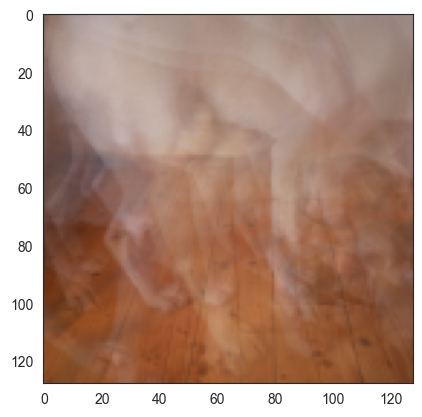

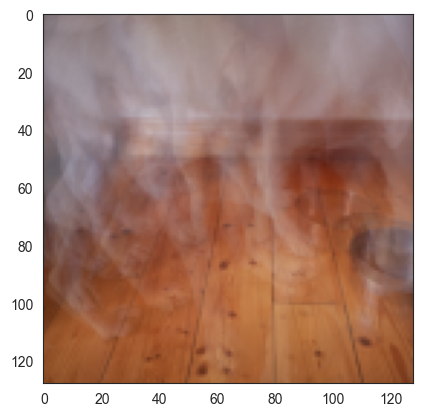

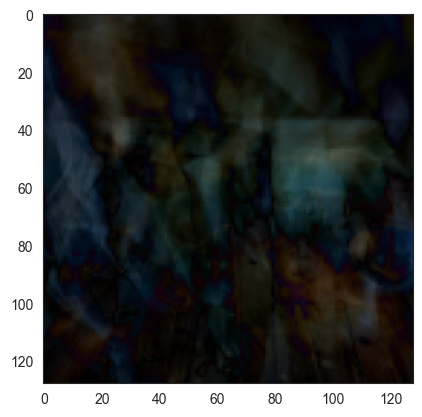

diff between means of same animal
0.015891297
std between same animal
0.09710477
0.25219804
0.2502429
1072.0


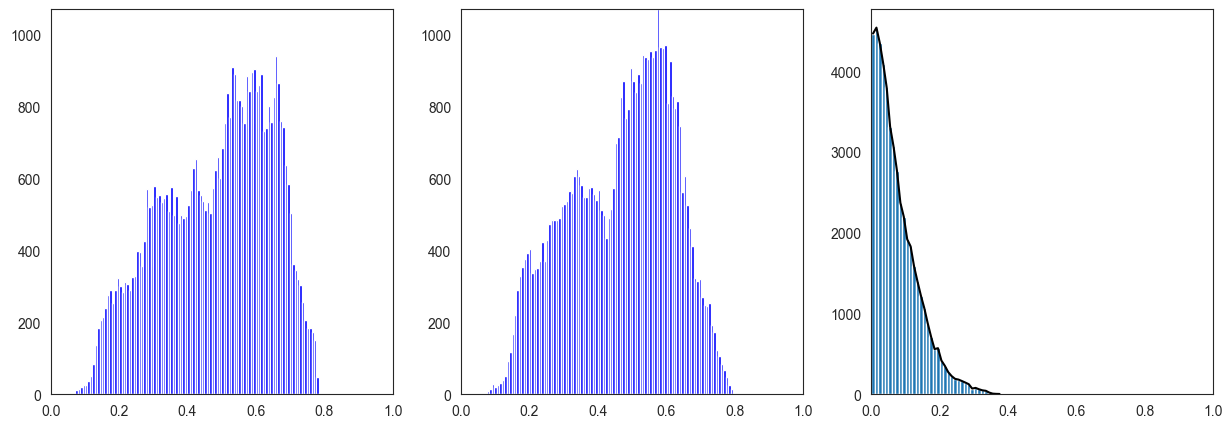

<class 'bool'>


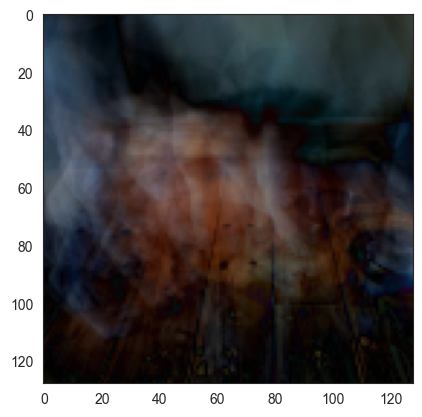

diff between means of two animals, smilla
-0.073715694
std between two animals
0.17762433
0.22265749
0.1523403
1072.0


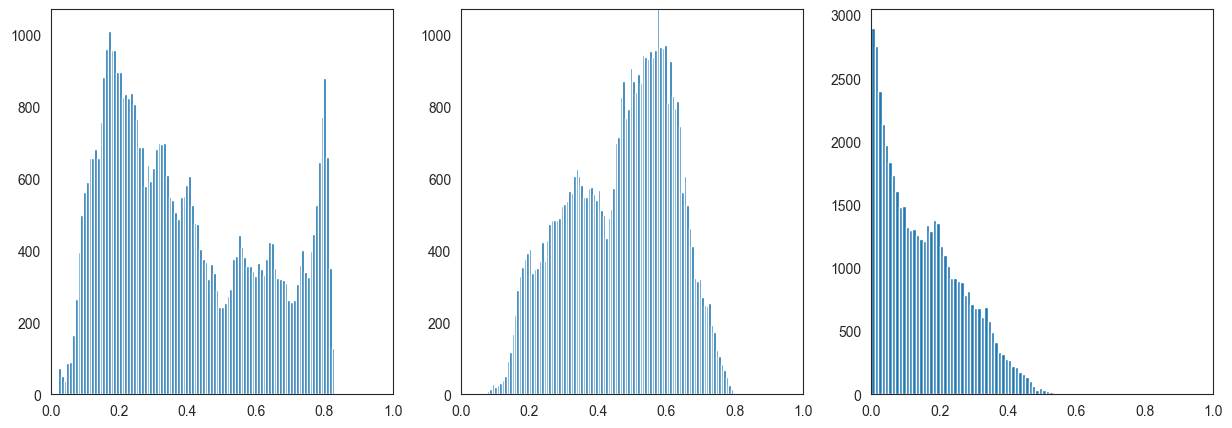

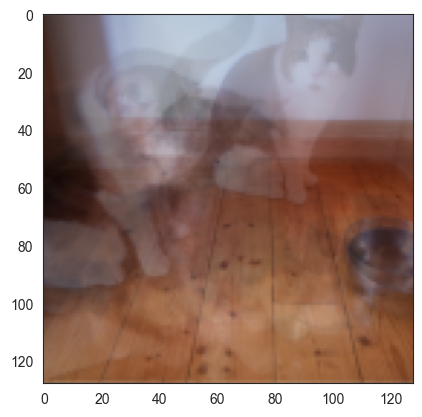

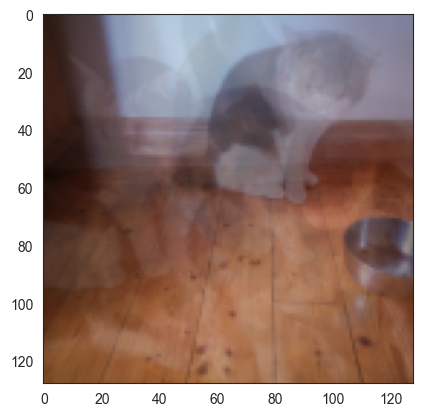

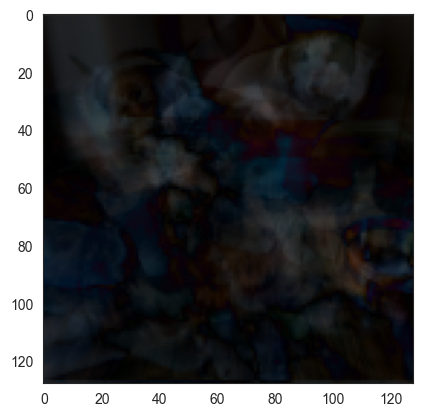

diff between means of same animal
0.01767785
std between same animal
0.08458539
0.26704475
0.27198255
1034.0


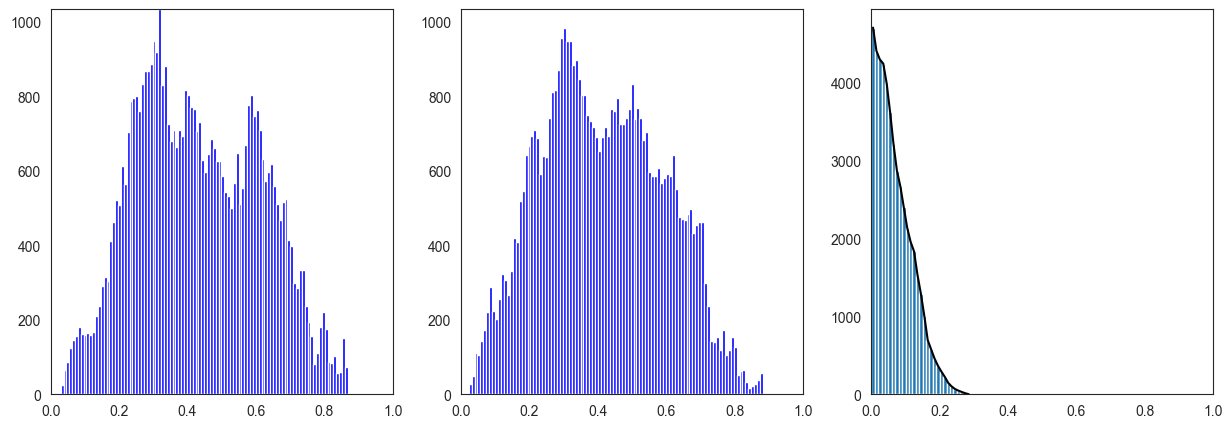

<class 'numpy.ndarray'>


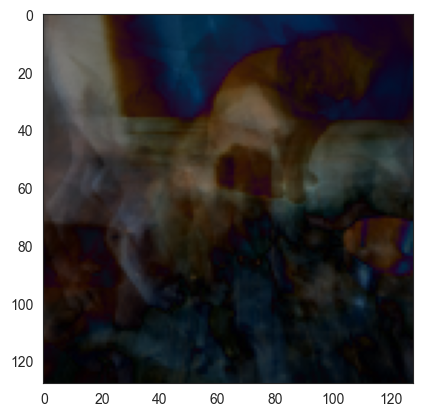

diff between means of two animals
0.06952468
std between two animals
0.15313442
0.16066742
0.17771557
984.0


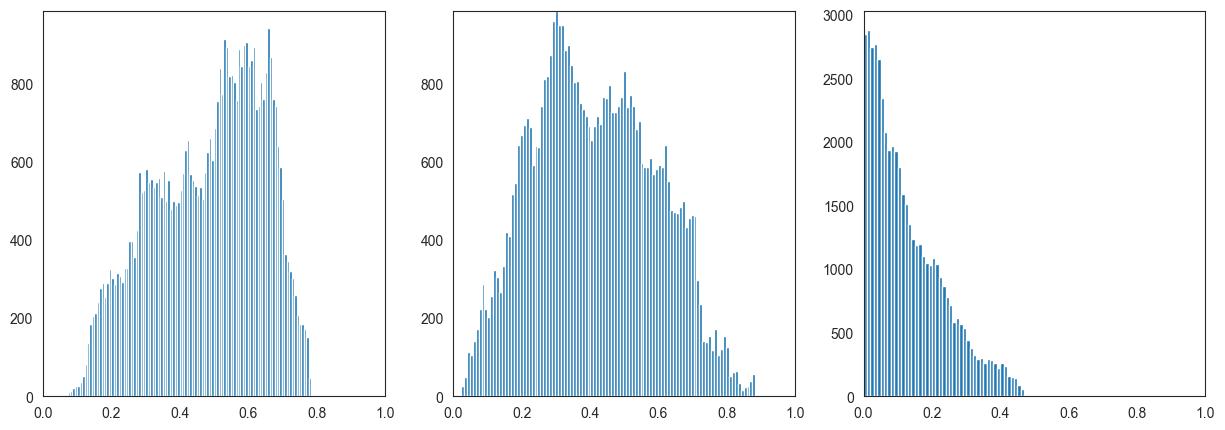

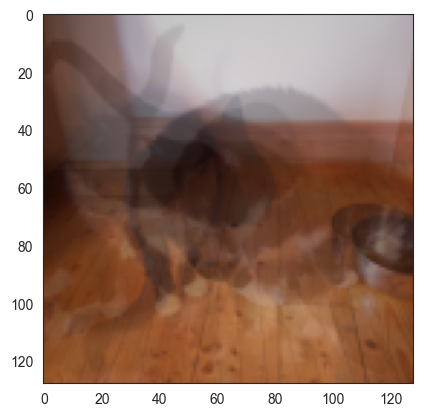

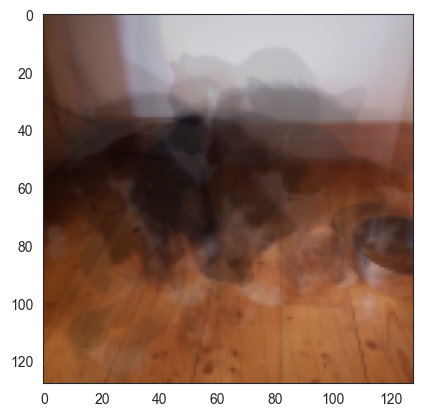

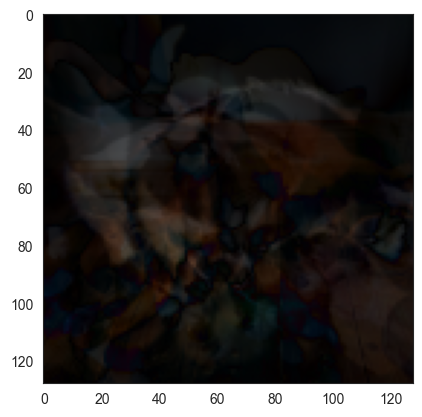

diff between means of same animal
0.018661996
std between same animal
0.07452048
0.29947332
0.30206195
1009.0


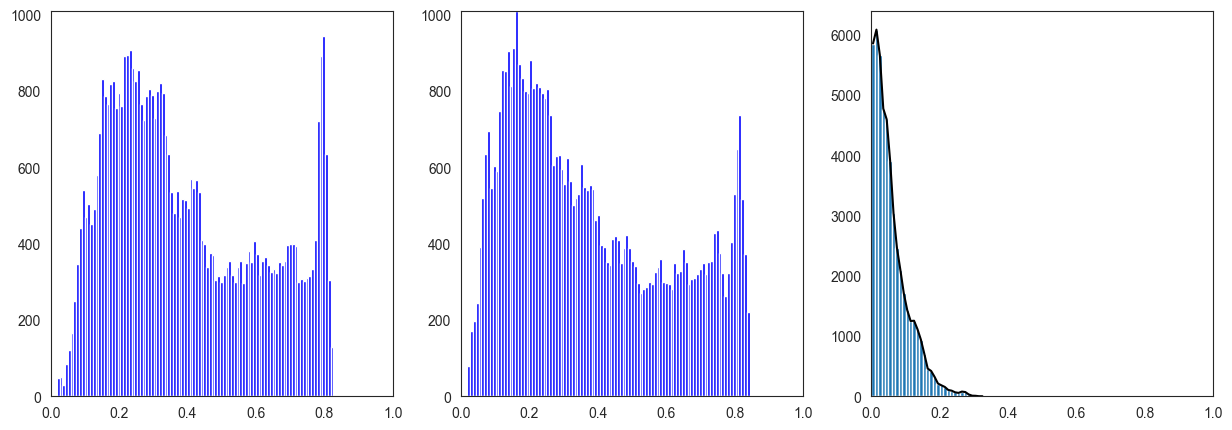

<class 'numpy.ndarray'>


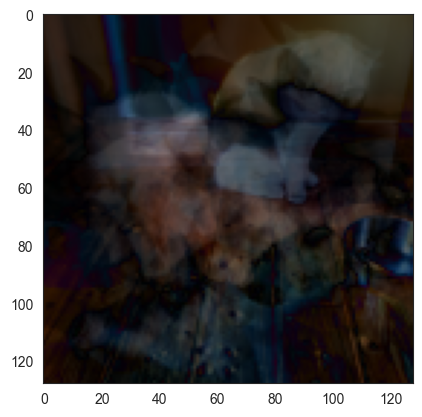

diff between means of two animals
0.035329193
std between two animals
0.1450613
0.17771557
0.2323624
1009.0


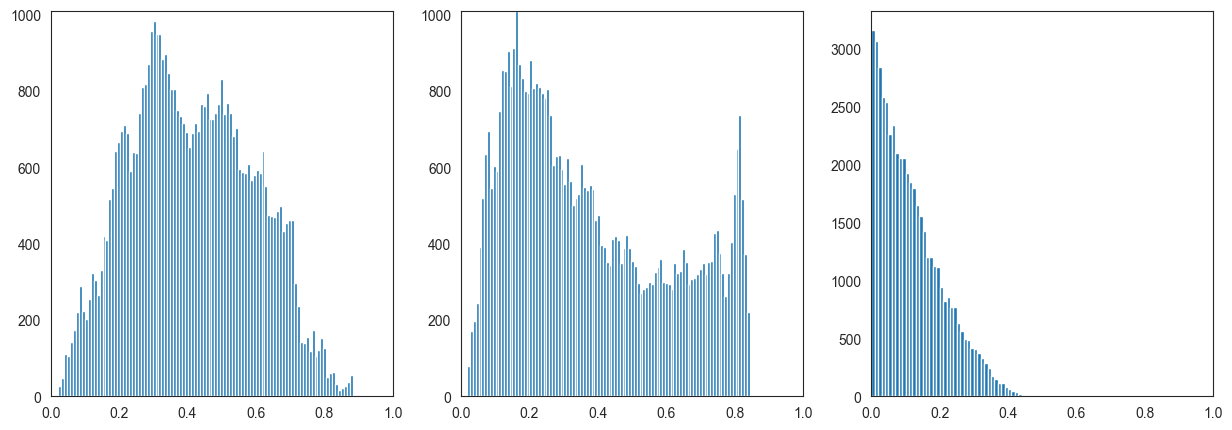

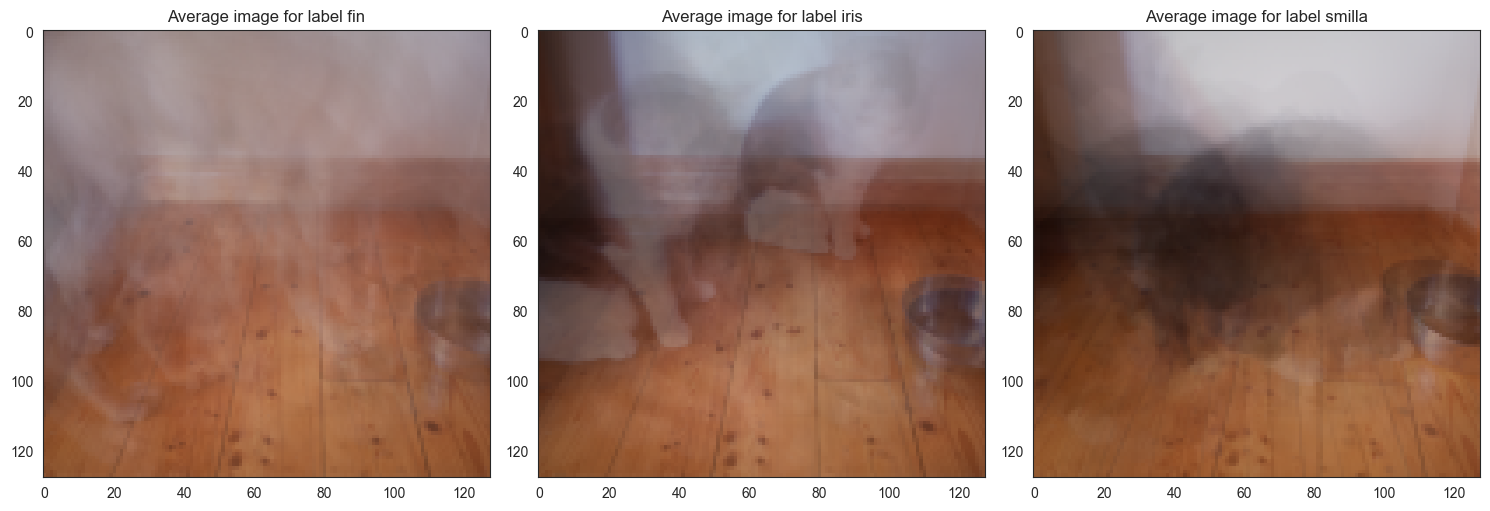

diff between all means of two animals
0.05865894
std between means of all animals
0.11321728
diff between all means of two animals
0.07108248
std between means of all animals
0.15940224
diff between all means of two animals
0.012423534
std between means of all animals
0.1108131


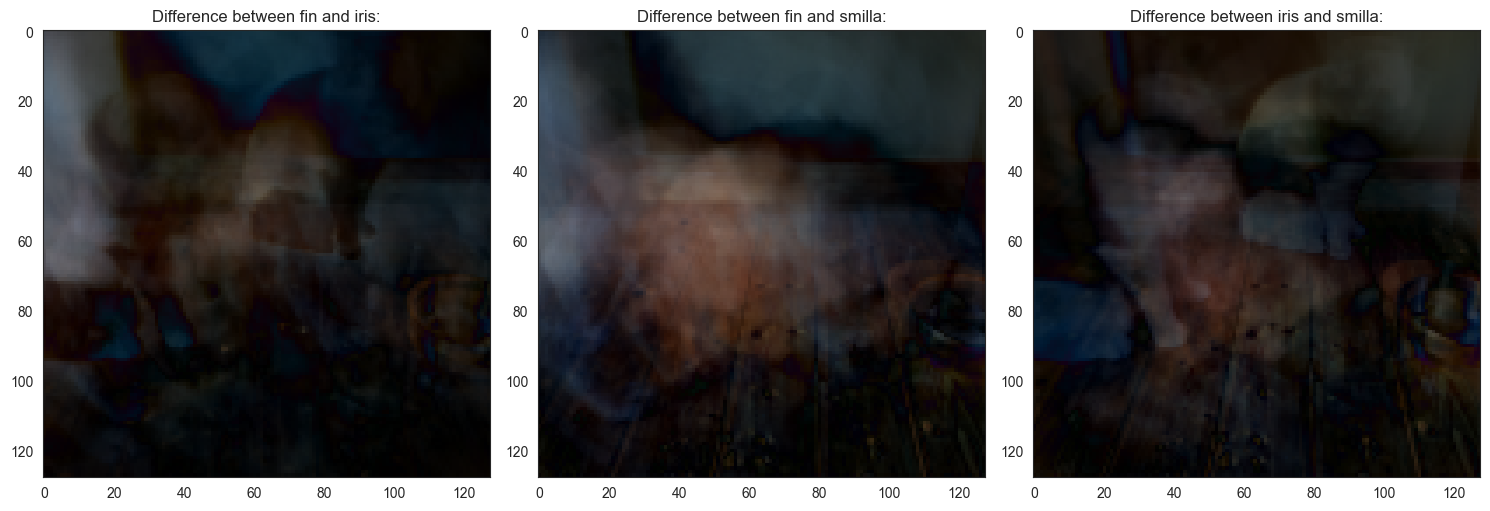

('fin', 'iris')
('fin', 'smilla')
('iris', 'smilla')


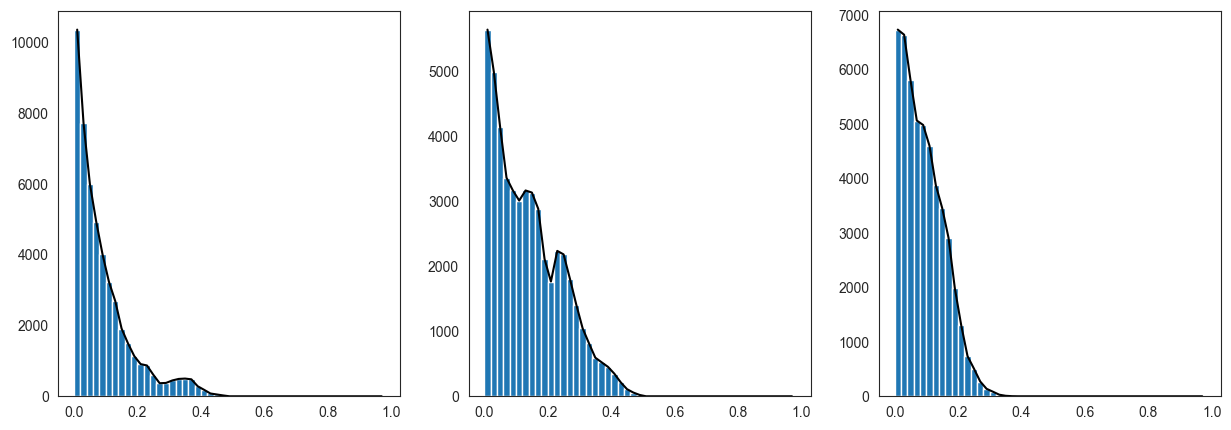

('fin', 'iris')
('fin', 'smilla')
('iris', 'smilla')


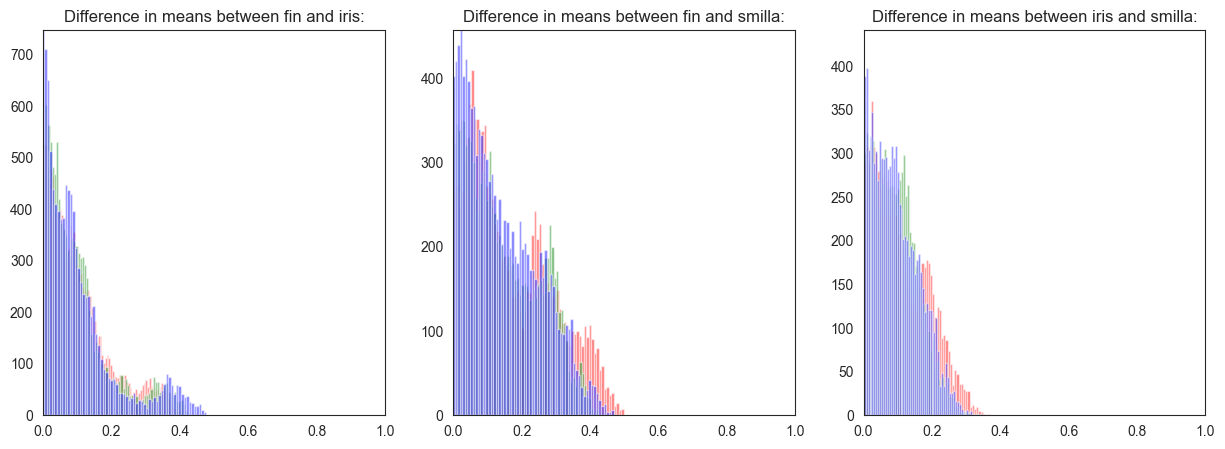

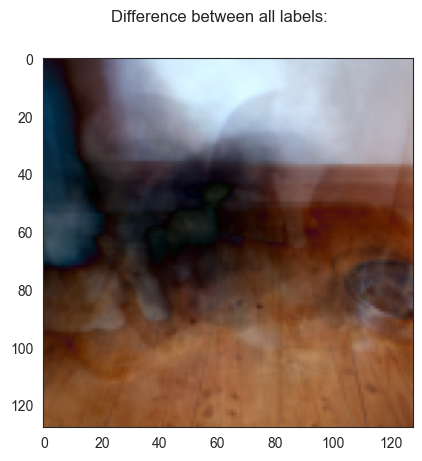

In [13]:

import itertools
import functools


def show_averages(X, y, labels):
    
    label_imgs = {'Means': {}, 'Vars': {}}
    #labels = np.unique(y)
    print(labels)
    
#    sm_mean = np.mean(X['smilla'])
    
    old = False
    
    for label in labels:

        y = y.reshape(-1, 1, 1)
        bool_mask = np.any(y == label, axis=1).reshape(-1)
        arr = X[bool_mask]
        
       # arr = arr[:, 40:120, 20:100, :]
        
        f10 = arr[10:20]
        n10 = arr[20:30]
        mean1 = np.mean(f10, axis=0)
        mean2 = np.mean(n10, axis=0)
        
       

        plt.imshow(mean1, cmap='gray')
        plt.show()
        plt.imshow(mean2, cmap='gray')
        plt.show()
        plt.imshow(abs(mean1 - mean2))
        plt.show()
        print('diff between means of same animal')
        print(np.mean(mean1 - mean2))
        print('std between same animal')
        print(np.std(mean1 - mean2))
        print(np.std(f10))
        print(np.std(n10))
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(131)
        _, _, patches = ax1.hist(mean1.flatten(), bins=100, color='b')
        y_lim_1 = np.array([i.get_height() for i in patches]).max()
        
        ax2 = fig.add_subplot(132)
        #ax2.hist(mean2.flatten(), bins=100)
        _, _, patches = ax2.hist(mean2.flatten(), bins=100, color='b')
        y_lim_2 = np.array([i.get_height() for i in patches]).max()
        
        ax3 = fig.add_subplot(133)
        #ax3.hist(abs(mean1 - mean2).flatten(), bins=100)
        data = abs(mean1 - mean2).flatten()
        y_val, bin_edges, _ = ax3.hist(data, bins=np.arange(min(data), max(data) + 0.01, 0.01))
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        ax3.plot(bin_centers, y_val, '-', c='black')

        #y_lim_3 = np.array([i.get_height() for i in patches]).max()

        y_lim = max(y_lim_1, y_lim_2)
        print(y_lim)
        ax1.set(xlim=(0,1), ylim=(0, y_lim))
        ax2.set(xlim=(0,1), ylim=(0, y_lim))
        ax3.set(xlim=(0,1))#, ylim=(0, y_lim))
        
        plt.show()

#         plt.hist(mean2.flatten(), bins=100)
# #        plt.set(xlim=(0,1))
#         plt.show()
#         plt.hist(abs(mean1 - mean2).flatten(), bins=100)
# #        plt.set(xlim=(0,1))
#         plt.show()
        #hist = np.histogram
        
       # sns.histplot((mean2[...].reshape(-1), mean1[...].reshape(-1)), bins=50)
       # plt.show()
       # sns.histplot(mean2[...].reshape(-1)- mean1[...].reshape(-1), bins=50)
       # plt.show()

        
        print(type(old))
        if str(type(old)) != "<class 'bool'>":
            plt.imshow(abs(old - mean2))
            plt.show()
            print('diff between means of two animals')
            print(np.mean(old - mean2))
            print('std between two animals')
            print(np.std(old - mean2))
            print(np.std(old))
            print(np.std(mean2))
            
            # sns.histplot(old[...,0].reshape(-1), bins=50)
            # plt.show()
            # sns.histplot(mean2[...,0].reshape(-1), bins=50)
            # plt.show()
            fig = plt.figure(figsize=(15, 5))
            ax1 = fig.add_subplot(131)
            n, bins, patches = ax1.hist(old.flatten(), bins=100)
            y_lim_1 = np.array([i.get_height() for i in patches]).max()
            
            ax2 = fig.add_subplot(132)
            #ax2.hist(mean2.flatten(), bins=100)
            n, bins, patches = ax2.hist(mean2.flatten(), bins=100)
            y_lim_2 = np.array([i.get_height() for i in patches]).max()
            
            ax3 = fig.add_subplot(133)
            #ax3.hist(abs(old - mean2).flatten(), bins=100)
            data = abs(old - mean2).flatten()
            n, bins, patches = ax3.hist(data, bins=np.arange(min(data), max(data) + 0.01, 0.01))
          #  y_lim_3 = np.array([i.get_height() for i in patches]).max()

            y_lim = max(y_lim_1, y_lim_2)
            print(y_lim)
            ax1.set(xlim=(0,1), ylim=(0, y_lim))
            ax2.set(xlim=(0,1), ylim=(0, y_lim))
            ax3.set(xlim=(0,1))#, ylim=(0, y_lim))
            plt.show()
            
            old = mean2
        else:
            #y = y.reshape(-1, 1, 1)
           # print(y)
            bool_mask = np.any(y == 'smilla', axis=1).reshape(-1)
           # print(bool_mask)

            arr_2 = X[bool_mask]
           # print(arr_2)
          #  arr_2 = arr_2[:, 40:120, 20:100, :]
            old = np.mean(arr_2[:30], axis=0)
            plt.imshow(abs(old - mean2))
            plt.show()
            print('diff between means of two animals, smilla')
            print(np.mean(old - mean2))
            print('std between two animals')
            print(np.std(old - mean2))
            print(np.std(old))
            print(np.std(mean2))
            # sns.histplot(old[...,0].reshape(-1), bins=50)
            # plt.show()
            # sns.histplot(mean2[...,0].reshape(-1), bins=50)
            # plt.show()
            
            fig = plt.figure(figsize=(15, 5))
            ax1 = fig.add_subplot(131)
            n, bins, patches = ax1.hist(old.flatten(), bins=100)
            y_lim_1 = np.array([i.get_height() for i in patches]).max()
            
            ax2 = fig.add_subplot(132)
            #ax2.hist(mean2.flatten(), bins=100)
            n, bins, patches = ax2.hist(mean2.flatten(), bins=100)
            y_lim_2 = np.array([i.get_height() for i in patches]).max()
            
            ax3 = fig.add_subplot(133)
            #ax3.hist(abs(old - mean2).flatten(), bins=100)
            data = abs(old - mean2).flatten()
            n, bins, patches = ax3.hist(data, bins=np.arange(min(data), max(data) + 0.01, 0.01))
            #y_lim_3 = np.array([i.get_height() for i in patches]).max()

            y_lim = max(y_lim_1, y_lim_2)
            print(y_lim)
            ax1.set(xlim=(0,1), ylim=(0, y_lim))
            ax2.set(xlim=(0,1), ylim=(0, y_lim))
            ax3.set(xlim=(0,1))#, ylim=(0, y_lim))
            plt.show()
            
            old = mean1
                

        # plt.imshow(np.std(arr[:30], axis=0))
        # plt.show()
        # plt.imshow(np.mean(arr[:30], axis=0))
        # plt.show()


        X_mean = np.mean(arr, axis=0)
        label_imgs['Means'][label] = X_mean
        
        label_imgs['Vars'][label] = np.std(arr, axis=0)
        # for channel in [0, 1, 2]:
        #     X_dev = np.std(arr[..., channel], axis=0)
        #     label_imgs['Vars'][label][channel] = X_dev
        # X_dev_all = np.std(arr, axis=0)
        # label_imgs['Vars'][label][4] = X_dev_all

    means = label_imgs['Means']
    vars = label_imgs['Vars']
    fig, axes = plt.subplots(nrows=1, ncols=len(labels), figsize=(len(labels)*5, 5))
    for idx, label in enumerate(labels):
        axes[idx].set_title(f"Average image for label {label}")
        axes[idx].imshow(means[label], cmap='gray')

    # for ch in [0, 1, 2]:
    #     for idx, label in enumerate(labels):
    #         axes[ch+1][idx].set_title(f"Channel {ch} variation image for label {label}")
    #         axes[ch+1][idx].imshow(vars[label][ch], cmap='gray')
            
    # for idx, label in enumerate(labels):
    #     axes[4][idx].set_title(f"All channel variation image for label {label}")
    #     axes[4][idx].imshow(vars[label][4], cmap='gray')
        
    
    # TODO: save figure
    plt.tight_layout()
    plt.show()

    # len(labels) should be the amount of combos
    combos_len = sum(1 for _ in itertools.combinations(labels, 2))
    nrows = max(1, combos_len // 3)
    ncols = combos_len + (combos_len % 3)
    x_size = ncols * 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(x_size, nrows*5))
    for idx, combo in enumerate(itertools.combinations(labels, 2)):
        # mc = (means[combo[0]] - means[combo[1]]).reshape(-1)
        # mc = np.array([c if c > 0 else 0 for c in mc]).astype('float').reshape(200, 200, 3)
        #print(mc)
        mc = abs(means[combo[0]] - means[combo[1]])
        print('diff between all means of two animals')
        print(np.mean(means[combo[0]] - means[combo[1]]))
        print('std between means of all animals')
        print(np.std(means[combo[0]] - means[combo[1]]))
        
        axes[idx].set_title(f"Difference between {combo[0]} and {combo[1]}:")
        axes[idx].imshow(mc, cmap='gray')
        
        #print(f'Difference between {combo[0]} and {combo[1]}:')
        #plt.imshow(mc)
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt. subplots(nrows=nrows, ncols=ncols, figsize=(x_size, nrows*5))
    for idx, combo in enumerate(itertools.combinations(labels, 2)):
        print(combo)
        params = axes[idx].hist(abs(means[combo[0]] - means[combo[1]]).flatten(), bins=np.arange(0, 1, 0.02))
        bin_centers = 0.5 * (params[1][1:] + params[1][:-1])
        axes[idx].plot(bin_centers, params[0], '-', c='black')
#    plt.hist((means[combo[0]] - means[combo[1]]).flatten(), bins=100)
    plt.show()


    fig, axes = plt. subplots(nrows=nrows, ncols=ncols, figsize=(x_size, nrows*5))
    for idx, combo in enumerate(itertools.combinations(labels, 2)):
        print(combo)
        axes[idx].set_title(f"Difference in means between {combo[0]} and {combo[1]}:")
        params = axes[idx].hist((means[combo[0]][...,0] - means[combo[1]][...,0]).flatten(), bins=100, alpha=0.5, color='r')
        y_lim = np.array([i.get_height() for i in params[2]]).max()
        params = axes[idx].hist((means[combo[0]][...,1] - means[combo[1]][...,1]).flatten(), bins=100, alpha=0.5, color='g')
        y_lim = max(np.array([i.get_height() for i in params[2]]).max(), y_lim)
        params = axes[idx].hist((means[combo[0]][...,2] - means[combo[1]][...,2]).flatten(), bins=100, alpha=0.5, color='b')
        y_lim = max(np.array([i.get_height() for i in params[2]]).max(), y_lim)
        axes[idx].set(ylim=(0, y_lim), xlim=(0,1))
        # bin_centers = 0.5 * (params[1][1:] + params[1][:-1])
        # axes[idx].plot(bin_centers, params[0], '-', c='black')
        
    plt.show()
    
 
    if len(labels) > 2:
        diffs = np.clip(abs(functools.reduce(lambda a, b: a - b, means.values())), 0, 1)
        plt.suptitle(f'Difference between all labels:')
        plt.imshow(diffs)
        plt.show()
        
    
   
show_averages(X_sample, y_sample, LABELS)



The resulting images show clearly that each label is distinguishable from the others.

### Save new image shape

In [ ]:
img_set_shape = X_sample.shape
print(img_set_shape)
joblib.dump(value=img_set_shape, filename=f"{output_path}/img_set_shape_extra.pkl")